In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imagenette2/imagenette2/noisy_imagenette.csv
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_8421.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_4681.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_29670.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_6380.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_14790.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_4490.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_8580.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_32420.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_12111.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_8572.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_27451.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_3782.JPEG
/kaggle/input/imagenette2/imagenette2/val/n01440764/n01440764_622.JPEG
/

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchmetrics import Accuracy

In [3]:
# Define the path to the Imagenette2 dataset
data_path = '/kaggle/input/imagenette2/imagenette2/train'

# Define the transforms to be applied to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset using ImageFolder
train_dataset = ImageFolder(root=data_path, transform=transform)


In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

print(f"Dataloader: {train_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x795f75bd97e0>
Length of train dataloader: 2368 batches of 4


In [5]:
class vgg16(nn.Module):
    def __init__(self):
        super(vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #64x128x128 to _ or 3x224x224 to 64x112x122
        self.conv2_1 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #128x64x64 to _ or 64x112x112 to 128x56x56
        self.conv3_1 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #256x32x32 to _ or 128x56x56 to 256x28x28
        self.conv4_1 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #512x16x16 to _ or 256x28x28 to 512x14x14
        self.conv5_1 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #512x8x8 to _ or 512x14x14 to 512x7x7
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            #nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10)
        )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.relu1_1(x)
        conv1_1_fm = x
        x = self.conv1_2(x)
        x = self.relu1_1(x)
        conv1_2_fm = x
        x = self.pool1(x)
        x = self.conv2_1(x)
        x = self.relu2_1(x)
        x = self.conv2_2(x)
        x = self.relu2_2(x)
        x = self.pool2(x)
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv3_2(x)
        x = self.relu3_2(x)
        x = self.conv3_3(x)
        x = self.relu3_3(x)
        x = self.pool3(x)
        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv4_2(x)
        x = self.relu4_2(x)
        x = self.conv4_3(x)
        x = self.relu4_3(x)
        x = self.pool4(x)
        x = self.conv5_1(x)
        x = self.relu5_1(x)
        conv5_1_fm = x
        x = self.conv5_2(x)
        x = self.relu5_2(x)
        conv5_2_fm = x
        x = self.conv5_3(x)
        x = self.relu5_3(x)
        conv5_3_fm = x
        x = self.pool5(x)
        x = x.view(x.size(0), -1)
        fc_latent_v = x
        x = self.classifier(x)
        return [x, fc_latent_v,conv5_1_fm, conv5_2_fm, conv5_3_fm, conv1_1_fm, conv1_2_fm]
               
#model_clf = vgg16()        
        

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
accuracy_metric = Accuracy(task="multiclass", num_classes=10)
accuracy_metric.to(device)
model_clf = vgg16() 
model_clf.load_state_dict(torch.load('/kaggle/input/classification-model1/model_clf.pth'))
model_clf.eval()

vgg16(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(256, 512, kern

In [7]:
def noise_generate(img, t):
    width, height = img.shape[1], img.shape[2]
    max_distance = torch.norm(torch.ones((3, 224, 224), dtype=torch.float32) * 255)
    d = t * max_distance
    norm_img = torch.norm(img)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    random_tensor = torch.randn(3, 224, 224).to(device)
    normalized_random_tensor = random_tensor / torch.norm(random_tensor)
    new_tensor = img + d * normalized_random_tensor * norm_img
    
    ED1 = torch.mean(torch.norm(img - new_tensor))
    return new_tensor


In [8]:
#[x, fc_latent_v,conv5_1_fm, conv5_2_fm, conv5_3_fm, conv1_1_fm, conv1_2_fm]
class SemanticLoss(torch.nn.Module):
    def __init__(self):
        super(SemanticLoss, self).__init__()
        
    def forward(self, original_image_feature_maps, generated_image_feature_maps, original_image, generated_image):
        CL = torch.mean(torch.norm(original_image_feature_maps[2] - generated_image_feature_maps[2], dim = 1))
        CL += torch.mean(torch.norm(original_image_feature_maps[3] - generated_image_feature_maps[3], dim = 1))
        CL += torch.mean(torch.norm(original_image_feature_maps[4] - generated_image_feature_maps[4], dim = 1))
        
        v1 = original_image_feature_maps[1]
        v2 = generated_image_feature_maps[1]
        
        KL = F.kl_div(F.log_softmax(v1[0],dim = 0), F.softmax(v2[0], dim = 0))
        KL += F.kl_div(F.log_softmax(v2[0],dim = 0), F.softmax(v1[0], dim = 0))
        
        noise = noise_generate(original_image, 0.1)
        
        ED = torch.mean(torch.norm(generated_image - noise))
       
        #print("Euclidean Distance :", ED)
        
        #print("KL divergence :", KL)
        
        #print("Euclidean Distance with noise :", ED2)
        
        loss = ED + (KL * 100000) + CL
        return loss

In [9]:
class perturbation_Classification_loss(torch.nn.Module):
    def __init__(self):
        super(perturbation_Classification_loss, self).__init__()
        self.cls_loss = nn.CrossEntropyLoss()
        
    def forward(self, original_image_final_output, generated_image_final_output):
        o_pred = torch.argmax(original_image_final_output, dim = 1)
        loss = self.cls_loss(generated_image_final_output, o_pred)
        return loss

In [10]:
def matching_accuracy(original_image_output, generated_image_output):
    with torch.no_grad():
        o_pred = torch.argmax(original_image_output, dim=1)
        g_pred = torch.argmax(generated_image_output, dim=1)
        correct = o_pred.eq(g_pred).sum().item()
        acc = correct / len(o_pred)
    return acc

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
AE = Autoencoder()

In [12]:
AE.to(device)
model_clf.to(device)
optimizerAE = torch.optim.Adam(params = AE.parameters(), lr = 0.001)

In [13]:
#AE training
train_loss = 0
match_acc = 0

epochs = 6
model_clf.eval()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    for batch, (x, y) in tqdm(enumerate(train_dataloader)):
        AE.train()
        x = x.to(device)
        lossS = SemanticLoss()
        lossS = lossS(model_clf(x), model_clf(AE(x)), x, AE(x))
        
        train_loss += lossS
        match_acc += matching_accuracy(model_clf(x)[0], model_clf(AE(x))[0])
        
        optimizerAE.zero_grad()
        lossS.backward()
        optimizerAE.step()
    train_loss /= len(train_dataloader)
    match_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Matching Accuracy {match_acc:.2f}%")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
-------


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train loss: 19034598.00000 | Matching Accuracy 0.53%
Epoch: 1
-------


0it [00:00, ?it/s]

Train loss: 19037392.00000 | Matching Accuracy 0.78%
Epoch: 2
-------


0it [00:00, ?it/s]

Train loss: 19038246.00000 | Matching Accuracy 0.88%
Epoch: 3
-------


0it [00:00, ?it/s]

Train loss: 19036776.00000 | Matching Accuracy 0.89%
Epoch: 4
-------


0it [00:00, ?it/s]

Train loss: 19037098.00000 | Matching Accuracy 0.89%
Epoch: 5
-------


0it [00:00, ?it/s]

Train loss: 19039618.00000 | Matching Accuracy 0.89%


In [14]:
#torch.save(AE.state_dict(), '/kaggle/working/Perturbation_generator.pth')

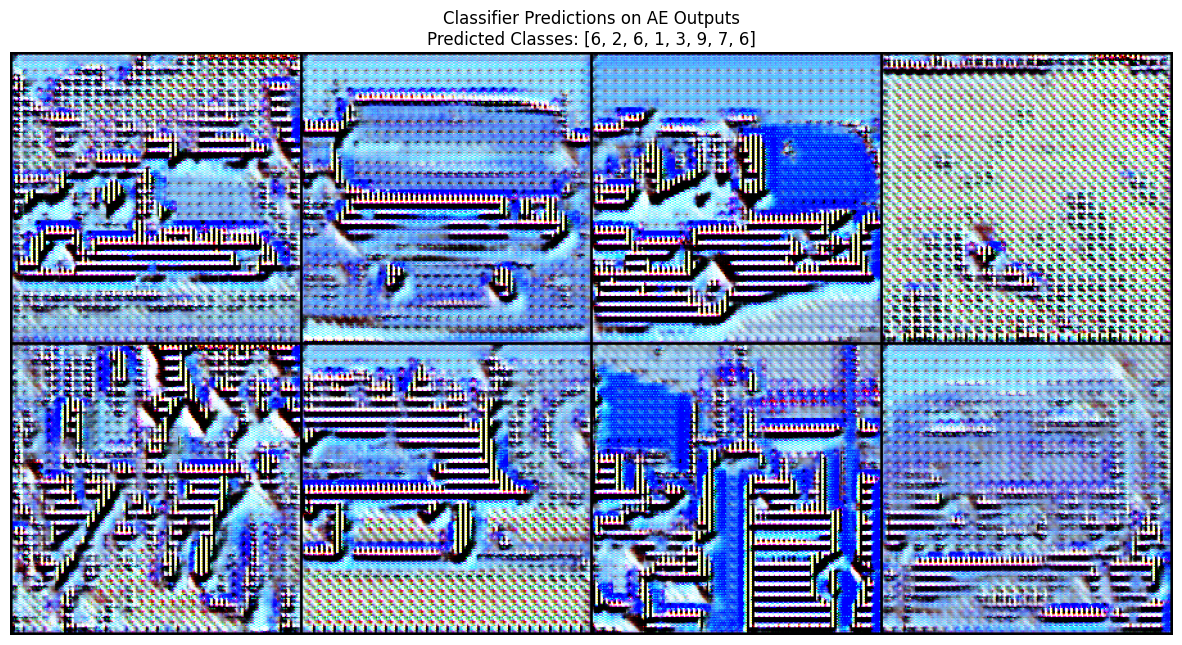

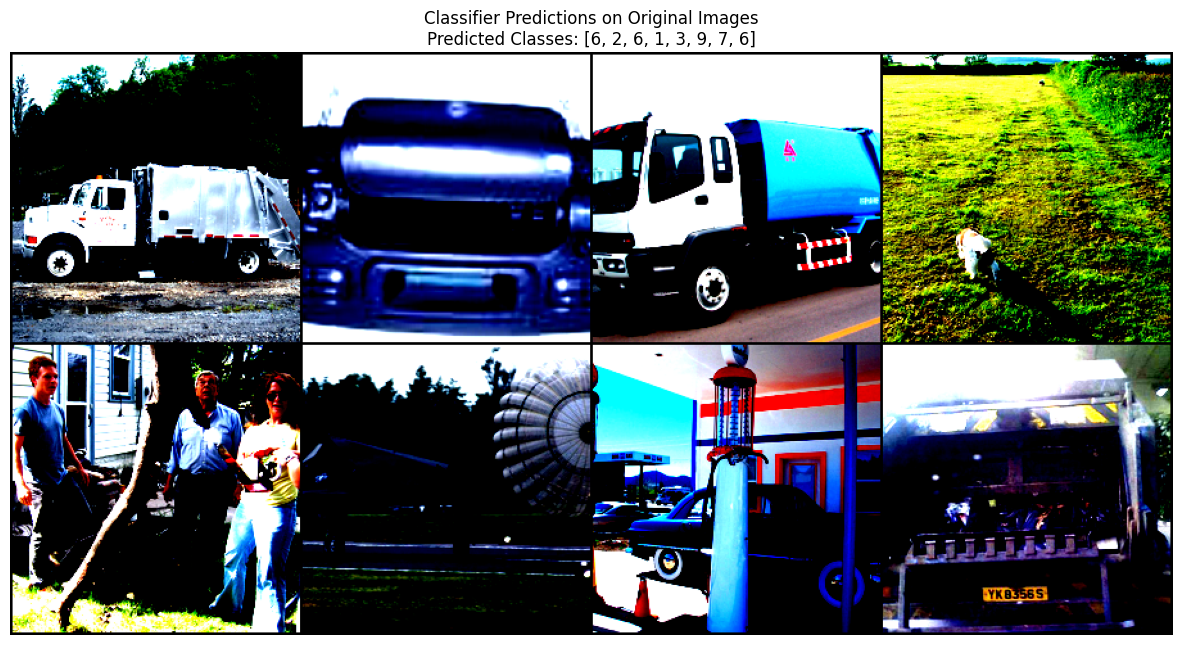

In [15]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def display_random_images(dataset, AE_model, classifier_model, num_images=8):
    AE_model.eval()
    classifier_model.eval()

    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)

    for batch in data_loader:
        original_images, _ = batch

        AE_outputs = AE_model(original_images)

        classifier_outputs_original = classifier_model(original_images)[0]
        classifier_outputs_AE = classifier_model(AE_outputs)[0]

        plot_predictions(AE_outputs, classifier_outputs_AE, title="Classifier Predictions on AE Outputs")
        plot_predictions(original_images, classifier_outputs_original, title="Classifier Predictions on Original Images")

        break

def plot_images(images, title):
    images = make_grid(images, nrow=4).permute(1, 2, 0).numpy()

    plt.figure(figsize=(15, 15))  # Adjusted figure size
    plt.imshow(images)
    plt.title(title)
    plt.axis("off")
    plt.show()

def plot_predictions(images, predictions, title):
    predicted_classes = torch.argmax(predictions, dim=1)

    images = make_grid(images, nrow=4).permute(1, 2, 0).numpy()

    plt.figure(figsize=(15, 15))  # Adjusted figure size
    plt.imshow(images)
    plt.title(f"{title}\nPredicted Classes: {predicted_classes.tolist()}")
    plt.axis("off")
    plt.show()

# Assuming you have already defined AE and model_clf
AE.to('cpu')
model_clf.to('cpu')

# Assuming you have also defined train_dataset
display_random_images(train_dataset, AE, model_clf, num_images=8)
